## 1. Setup and Imports

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import json
import os
from sklearn.metrics import roc_auc_score, roc_curve, auc

warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('Set2')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [2]:
# Import custom modules
import sys
sys.path.append('..')

from src.features.aggregation import create_aggregation_features
from src.features.interactions import create_interaction_features
from src.features.temporal import create_temporal_features
from src.features.missing_features import create_missing_value_features
from src.models.cross_validation import (
    RobustCrossValidator,
    TimeSeriesCV,
    EnsembleCrossValidator,
    quick_cv_comparison,
    analyze_cv_consistency
)
from src.utils import (
    plot_roc_curve,
    plot_feature_importance,
    evaluate_model,
    print_evaluation_metrics,
    reduce_mem_usage
)

print("✓ Custom modules imported successfully")

✓ Custom modules imported successfully


## 2. Load Data

In [3]:
# Load data
print("Loading data...\n")

train_transaction = pd.read_csv('../data/train_transaction.csv')
train_identity = pd.read_csv('../data/train_identity.csv')

print(f"Train transaction shape: {train_transaction.shape}")
print(f"Train identity shape: {train_identity.shape}")

# Merge datasets
train_df = train_transaction.merge(train_identity, on='TransactionID', how='left')
print(f"\nMerged train shape: {train_df.shape}")
print(f"Fraud rate: {train_df['isFraud'].mean()*100:.2f}%")

# Reduce memory
train_df = reduce_mem_usage(train_df)

print("\n✓ Data loaded successfully")

Loading data...

Train transaction shape: (590540, 394)
Train identity shape: (144233, 41)
Train transaction shape: (590540, 394)
Train identity shape: (144233, 41)

Merged train shape: (590540, 434)
Fraud rate: 3.50%

Merged train shape: (590540, 434)
Fraud rate: 3.50%
Memory usage decreased from 1955.37 MB to 1044.70 MB (46.6% reduction)

✓ Data loaded successfully
Memory usage decreased from 1955.37 MB to 1044.70 MB (46.6% reduction)

✓ Data loaded successfully


## 3. Create All Features

In [4]:
# Create all features from previous milestones
print("Creating all features...\n")

# Missing value features
train_df, missing_feature_names = create_missing_value_features(train_df)
print(f"✓ Created {len(missing_feature_names)} missing value features")

# Aggregation features
train_df, agg_feature_names = create_aggregation_features(train_df, target_col='TransactionAmt')
print(f"✓ Created {len(agg_feature_names)} aggregation features")

# Interaction features
train_df, interaction_feature_names = create_interaction_features(train_df, min_samples=10)
print(f"✓ Created {len(interaction_feature_names)} interaction features")

# Temporal features
train_df, temporal_feature_names = create_temporal_features(train_df, include_velocity=False)
print(f"✓ Created {len(temporal_feature_names)} temporal features")

print(f"\nFinal shape: {train_df.shape}")

Creating all features...


CREATING MISSING VALUE FEATURES

Creating basic missing value indicators...
  Creating indicators for 322 columns with >5% missing
  Created 52 basic missing indicators
Creating group-level missing features...
  Creating indicators for 322 columns with >5% missing
  Created 52 basic missing indicators
Creating group-level missing features...
  Created 20 group missing features
Creating missing value co-occurrence features...
  Created 20 group missing features
Creating missing value co-occurrence features...
  Created 12 co-occurrence features
Creating card-related missing pattern features...
  Created 12 co-occurrence features
Creating card-related missing pattern features...
  Created 8 card missing features
Creating unusual missing pattern features...
  Created 8 card missing features
Creating unusual missing pattern features...
  Created 8 unusual pattern features
Creating missing value interaction features...
  Created 8 unusual pattern features
Creating

## 4. Load Selected Features and Best Parameters

In [5]:
# Load selected features from M12
try:
    with open('../models/selected_features.json', 'r') as f:
        selected_info = json.load(f)
    selected_features = selected_info['features']
    print(f"✓ Loaded {len(selected_features)} selected features from M12")
except:
    selected_features = None
    print("Note: Using all features (M12 feature selection not found)")

# Load best parameters from M11
try:
    with open('../models/staged_tuned_params.json', 'r') as f:
        best_params = json.load(f)
    print("✓ Loaded tuned parameters from M11")
except:
    best_params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'learning_rate': 0.01,
        'num_leaves': 256,
        'max_depth': 12,
        'min_child_samples': 50,
        'subsample': 0.9,
        'subsample_freq': 1,
        'colsample_bytree': 0.7,
        'reg_alpha': 0.5,
        'reg_lambda': 0.5,
        'n_jobs': -1,
        'random_state': 42,
        'verbose': -1
    }
    print("Note: Using default parameters")

✓ Loaded 286 selected features from M12
✓ Loaded tuned parameters from M11


## 5. Prepare Data

In [6]:
# Prepare features
print("Preparing data for modeling...\n")

# Separate target
y = train_df['isFraud']
X = train_df.drop(['isFraud', 'TransactionID'], axis=1)

# Use selected features if available
if selected_features is not None:
    available_features = [f for f in selected_features if f in X.columns]
    X = X[available_features]
    print(f"Using {len(available_features)} selected features")
else:
    print(f"Using all {X.shape[1]} features")

# Encode categorical features
from sklearn.preprocessing import LabelEncoder

categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Encoding {len(categorical_features)} categorical features...")

for col in categorical_features:
    le = LabelEncoder()
    X[col] = X[col].astype(str).replace('nan', 'missing')
    X[col] = le.fit_transform(X[col])

# Fill missing values
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
for col in numeric_features:
    if X[col].isnull().any():
        X[col] = X[col].fillna(X[col].median())

print(f"\n✓ Final feature count: {X.shape[1]}")
print(f"✓ Sample count: {X.shape[0]:,}")
print("✓ Data preparation complete")

Preparing data for modeling...

Using 286 selected features
Encoding 19 categorical features...
Using 286 selected features
Encoding 19 categorical features...

✓ Final feature count: 286
✓ Sample count: 590,540
✓ Data preparation complete

✓ Final feature count: 286
✓ Sample count: 590,540
✓ Data preparation complete


## 6. Compare CV Strategies

In [7]:
# Compare different CV strategies
print("Comparing cross-validation strategies...\n")
print("This will take 15-30 minutes...\n")

cv_comparison = quick_cv_comparison(
    X, y,
    model_params=best_params,
    strategies=['time_series', 'stratified'],
    n_splits=5
)

print("\n✓ CV strategy comparison complete")

Comparing cross-validation strategies...

This will take 15-30 minutes...

Comparing CV strategies...


Testing time_series CV...
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[417]	train's auc: 0.998612	valid's auc: 0.982679
Early stopping, best iteration is:
[417]	train's auc: 0.998612	valid's auc: 0.982679
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[652]	train's auc: 0.999633	valid's auc: 0.98414
Early stopping, best iteration is:
[652]	train's auc: 0.999633	valid's auc: 0.98414
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[698]	train's auc: 0.999713	valid's auc: 0.984648
Early stopping, best iteration is:
[698]	train's auc: 0.999713	valid's auc:

## 7. Visualize CV Strategy Comparison

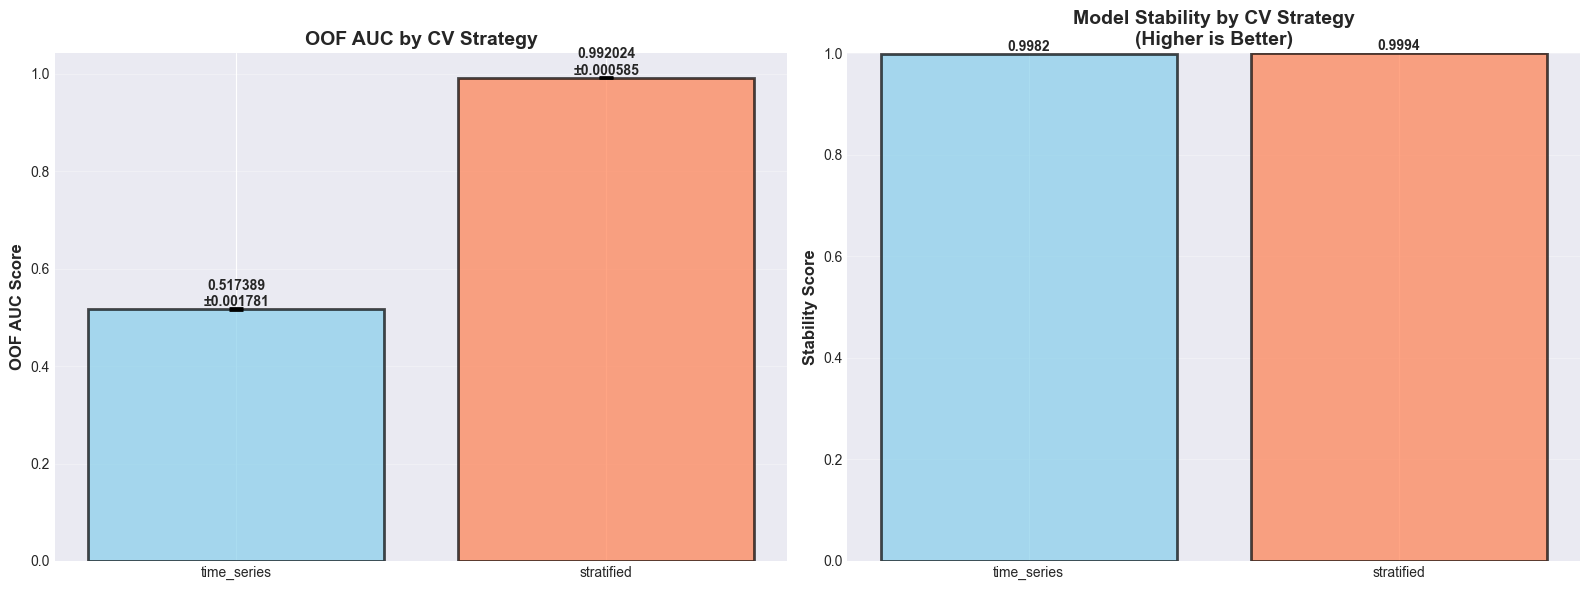


Best CV Strategy:
  Strategy: stratified
  OOF AUC: 0.992024
  Stability: 0.9994


In [8]:
# Visualize CV comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: OOF AUC comparison
ax = axes[0]
strategies = cv_comparison['strategy'].values
oof_aucs = cv_comparison['oof_auc'].values
std_aucs = cv_comparison['std_auc'].values

bars = ax.bar(strategies, oof_aucs, color=['skyblue', 'coral'], 
              edgecolor='black', linewidth=2, alpha=0.7)
ax.errorbar(strategies, oof_aucs, yerr=std_aucs, fmt='none', 
            color='black', capsize=5, capthick=2)

# Add value labels
for bar, oof, std in zip(bars, oof_aucs, std_aucs):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{oof:.6f}\n±{std:.6f}',
            ha='center', va='bottom', fontweight='bold', fontsize=10)

ax.set_ylabel('OOF AUC Score', fontsize=12, fontweight='bold')
ax.set_title('OOF AUC by CV Strategy', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Plot 2: Stability comparison
ax = axes[1]
stability_scores = cv_comparison['stability_score'].values

bars = ax.bar(strategies, stability_scores, color=['skyblue', 'coral'],
              edgecolor='black', linewidth=2, alpha=0.7)

# Add value labels
for bar, score in zip(bars, stability_scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{score:.4f}',
            ha='center', va='bottom', fontweight='bold', fontsize=10)

ax.set_ylabel('Stability Score', fontsize=12, fontweight='bold')
ax.set_title('Model Stability by CV Strategy\n(Higher is Better)', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nBest CV Strategy:")
best_idx = cv_comparison['oof_auc'].idxmax()
best_strategy = cv_comparison.loc[best_idx, 'strategy']
best_auc = cv_comparison.loc[best_idx, 'oof_auc']
best_stability = cv_comparison.loc[best_idx, 'stability_score']

print(f"  Strategy: {best_strategy}")
print(f"  OOF AUC: {best_auc:.6f}")
print(f"  Stability: {best_stability:.4f}")

## 8. Detailed Time-Series CV Analysis

In [9]:
# Perform detailed time-series CV
print("Performing detailed time-series cross-validation...\n")
print("This will take 10-20 minutes...\n")

ts_validator = RobustCrossValidator(
    model_params=best_params,
    cv_strategy='time_series',
    n_splits=5,
    random_state=42,
    verbose=True
)

ts_results = ts_validator.cross_validate(
    X, y,
    num_boost_round=2000,
    early_stopping_rounds=100
)

print("\n✓ Time-series CV complete")

Performing detailed time-series cross-validation...

This will take 10-20 minutes...

Starting time_series cross-validation with 5 folds...

Fold 1/5
----------------------------------------------------------------------
Train: 472,432 samples, Fraud rate: 3.51%
Val:   118,108 samples, Fraud rate: 3.44%
Train: 472,432 samples, Fraud rate: 3.51%
Val:   118,108 samples, Fraud rate: 3.44%
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.992554	valid's auc: 0.979374
[100]	train's auc: 0.992554	valid's auc: 0.979374
[200]	train's auc: 0.995516	valid's auc: 0.981274
[200]	train's auc: 0.995516	valid's auc: 0.981274
[300]	train's auc: 0.997433	valid's auc: 0.982311
[300]	train's auc: 0.997433	valid's auc: 0.982311
[400]	train's auc: 0.998482	valid's auc: 0.982633
[400]	train's auc: 0.998482	valid's auc: 0.982633
[500]	train's auc: 0.999156	valid's auc: 0.982607
[500]	train's auc: 0.999156	valid's a

## 9. Analyze Model Stability

In [10]:
# Analyze stability
stability_metrics = ts_validator.analyze_stability()

print(f"\n{'='*70}")
print("MODEL STABILITY ANALYSIS")
print(f"{'='*70}")
print(f"OOF AUC:                    {ts_results['oof_auc']:.6f}")
print(f"Mean fold AUC:              {ts_results['mean_auc']:.6f}")
print(f"AUC std deviation:          {ts_results['std_auc']:.6f}")
print(f"Min fold AUC:               {ts_results['min_auc']:.6f}")
print(f"Max fold AUC:               {ts_results['max_auc']:.6f}")
print(f"AUC range:                  {ts_results['max_auc'] - ts_results['min_auc']:.6f}")
print(f"\nCoefficient of variation:   {stability_metrics['coefficient_of_variation']:.6f}")
print(f"Max fold difference:        {stability_metrics['max_fold_difference']:.6f}")
print(f"Max consecutive drop:       {stability_metrics['max_consecutive_drop']:.6f}")
print(f"Stability score:            {stability_metrics['stability_score']:.4f}")
print(f"{'='*70}")

# Interpretation
if stability_metrics['stability_score'] > 0.99:
    print("\n✓ Excellent stability - model is highly consistent")
elif stability_metrics['stability_score'] > 0.98:
    print("\n✓ Good stability - model is reliable")
elif stability_metrics['stability_score'] > 0.97:
    print("\n⚠ Moderate stability - some variance across folds")
else:
    print("\n⚠ Low stability - consider adjusting parameters or CV strategy")


MODEL STABILITY ANALYSIS
OOF AUC:                    0.517389
Mean fold AUC:              0.985041
AUC std deviation:          0.001781
Min fold AUC:               0.982679
Max fold AUC:               0.988017
AUC range:                  0.005338

Coefficient of variation:   0.001808
Max fold difference:        0.005338
Max consecutive drop:       0.002295
Stability score:            0.9982

✓ Excellent stability - model is highly consistent


## 10. Visualize Fold-by-Fold Performance

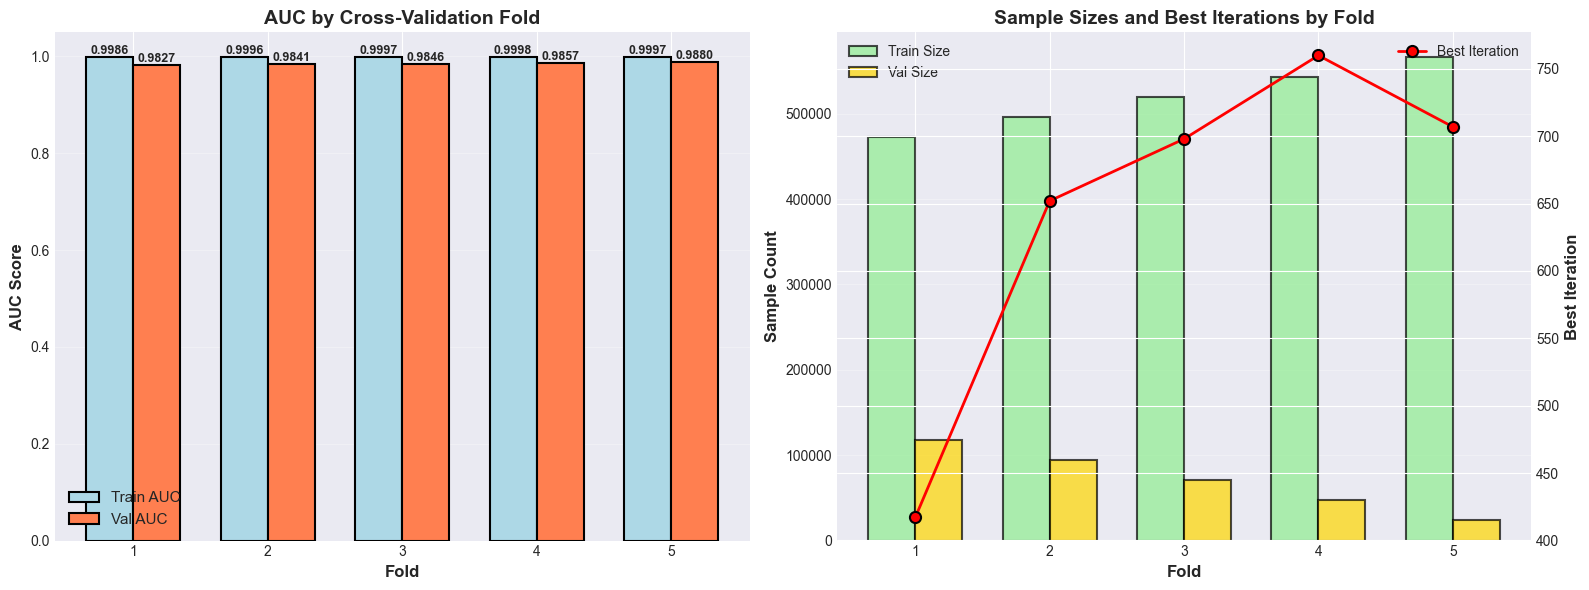

In [11]:
# Visualize fold performance
cv_results_df = pd.DataFrame(ts_validator.cv_results)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: AUC by fold
ax = axes[0]
folds = cv_results_df['fold']
train_aucs = cv_results_df['train_auc']
val_aucs = cv_results_df['val_auc']

x = np.arange(len(folds))
width = 0.35

bars1 = ax.bar(x - width/2, train_aucs, width, label='Train AUC', 
               color='lightblue', edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, val_aucs, width, label='Val AUC',
               color='coral', edgecolor='black', linewidth=1.5)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Fold', fontsize=12, fontweight='bold')
ax.set_ylabel('AUC Score', fontsize=12, fontweight='bold')
ax.set_title('AUC by Cross-Validation Fold', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(folds)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

# Plot 2: Sample sizes and best iterations
ax = axes[1]
ax2 = ax.twinx()

train_sizes = cv_results_df['train_size']
val_sizes = cv_results_df['val_size']
best_iters = cv_results_df['best_iteration']

ax.bar(x - width/2, train_sizes, width, label='Train Size',
       color='lightgreen', edgecolor='black', linewidth=1.5, alpha=0.7)
ax.bar(x + width/2, val_sizes, width, label='Val Size',
       color='gold', edgecolor='black', linewidth=1.5, alpha=0.7)

ax2.plot(x, best_iters, 'ro-', linewidth=2, markersize=8, 
         label='Best Iteration', markeredgecolor='black', markeredgewidth=1.5)

ax.set_xlabel('Fold', fontsize=12, fontweight='bold')
ax.set_ylabel('Sample Count', fontsize=12, fontweight='bold')
ax2.set_ylabel('Best Iteration', fontsize=12, fontweight='bold')
ax.set_title('Sample Sizes and Best Iterations by Fold', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(folds)
ax.legend(loc='upper left', fontsize=10)
ax2.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 11. OOF Prediction Analysis

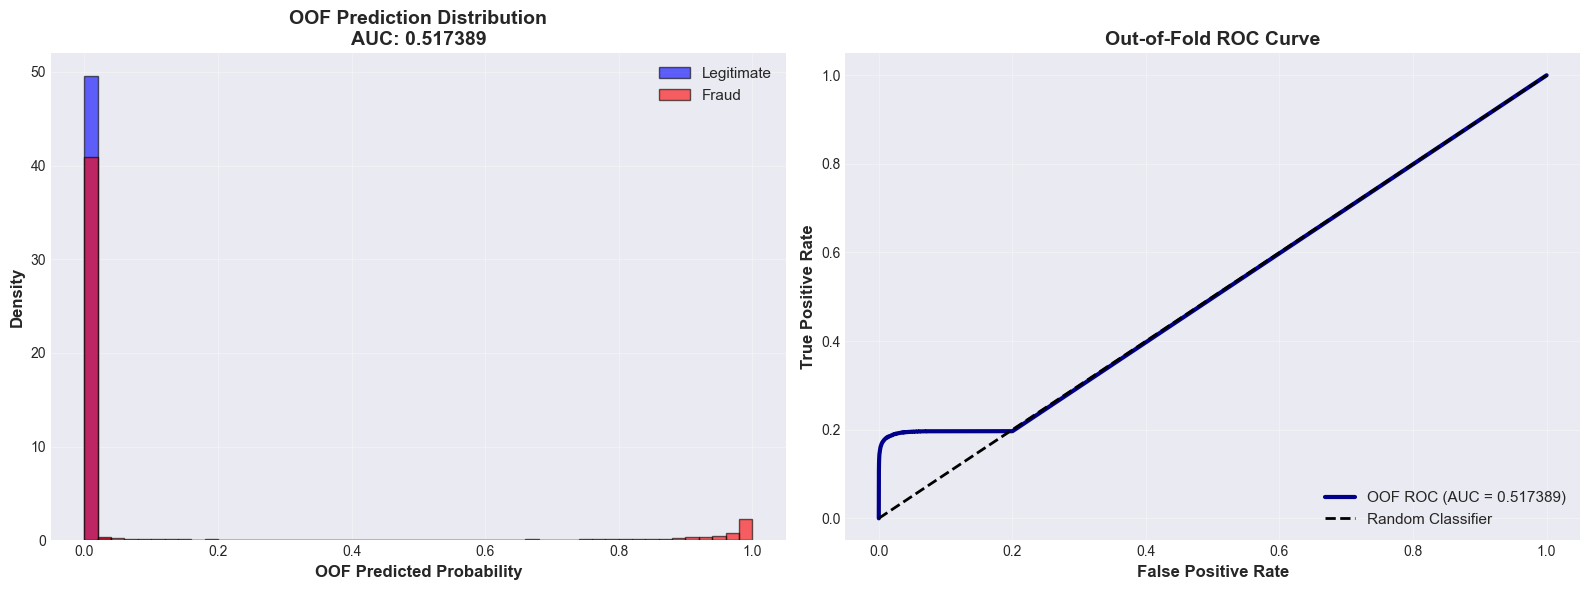


OOF Prediction Statistics:
Mean (Legitimate): 0.001585
Mean (Fraud):      0.127113
Std (Legitimate):  0.020506
Std (Fraud):       0.306069
Min:               0.000000
Max:               0.999979


In [12]:
# Analyze OOF predictions
oof_predictions = ts_results['oof_predictions']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: OOF prediction distribution
ax = axes[0]
ax.hist(oof_predictions[y == 0], bins=50, alpha=0.6, label='Legitimate',
        edgecolor='black', density=True, color='blue')
ax.hist(oof_predictions[y == 1], bins=50, alpha=0.6, label='Fraud',
        edgecolor='black', density=True, color='red')

ax.set_xlabel('OOF Predicted Probability', fontsize=12, fontweight='bold')
ax.set_ylabel('Density', fontsize=12, fontweight='bold')
ax.set_title(f'OOF Prediction Distribution\nAUC: {ts_results["oof_auc"]:.6f}',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Plot 2: ROC curve
ax = axes[1]
fpr, tpr, thresholds = roc_curve(y, oof_predictions)
roc_auc = auc(fpr, tpr)

ax.plot(fpr, tpr, linewidth=3, label=f'OOF ROC (AUC = {roc_auc:.6f})',
        color='darkblue')
ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')

ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('Out-of-Fold ROC Curve', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical analysis
print("\nOOF Prediction Statistics:")
print(f"{'='*70}")
print(f"Mean (Legitimate): {oof_predictions[y == 0].mean():.6f}")
print(f"Mean (Fraud):      {oof_predictions[y == 1].mean():.6f}")
print(f"Std (Legitimate):  {oof_predictions[y == 0].std():.6f}")
print(f"Std (Fraud):       {oof_predictions[y == 1].std():.6f}")
print(f"Min:               {oof_predictions.min():.6f}")
print(f"Max:               {oof_predictions.max():.6f}")
print(f"{'='*70}")

## 12. Feature Importance Analysis

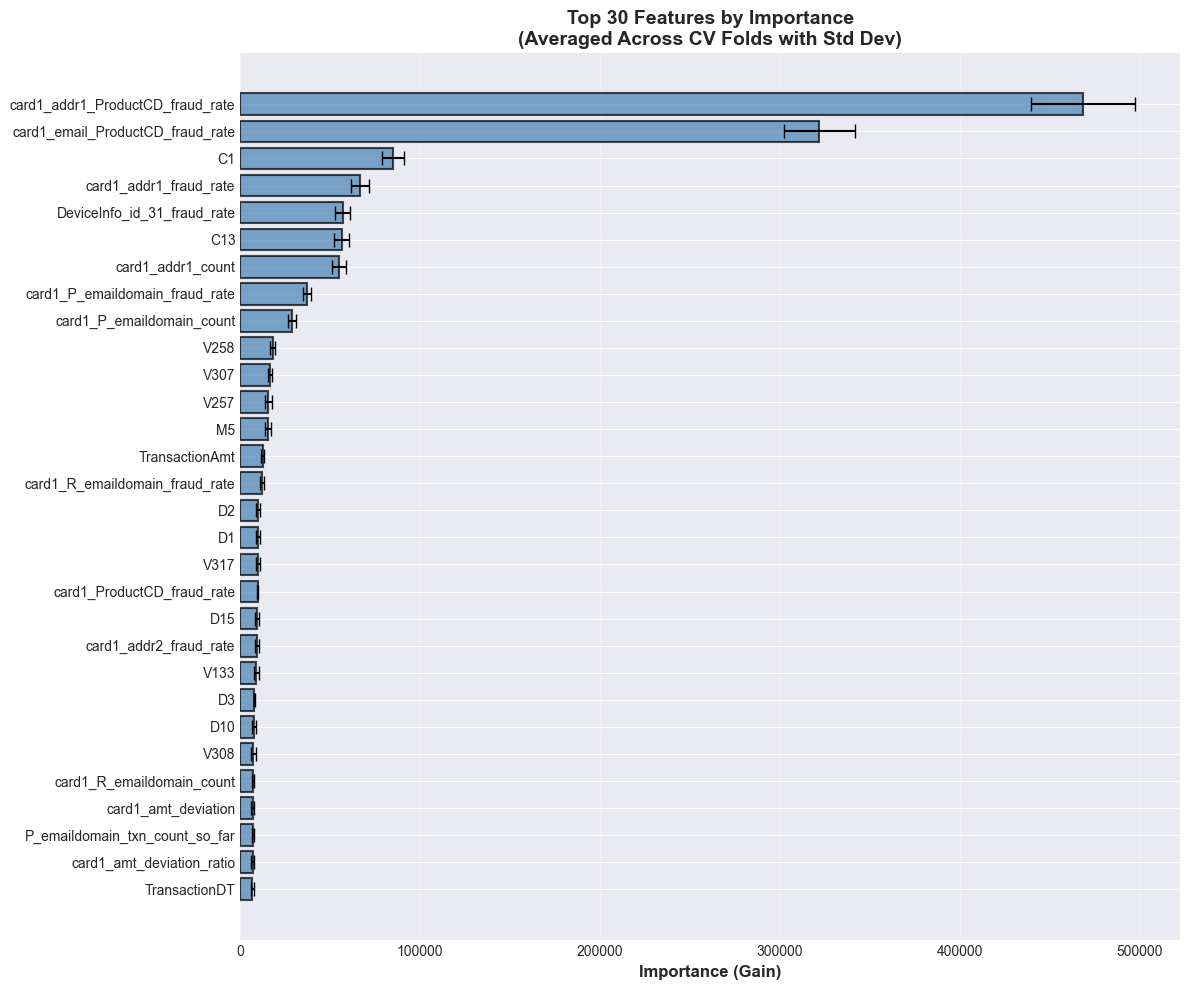


Top 10 Most Important Features:
card1_addr1_ProductCD_fraud_rate           468692.8 ±  29006.0
card1_email_ProductCD_fraud_rate           322069.9 ±  19621.4
C1                                          84668.4 ±   6098.3
card1_addr1_fraud_rate                      66566.1 ±   4871.9
DeviceInfo_id_31_fraud_rate                 56846.8 ±   4048.5
C13                                         56509.8 ±   4186.1
card1_addr1_count                           54926.8 ±   3760.1
card1_P_emaildomain_fraud_rate              37093.9 ±   2283.3
card1_P_emaildomain_count                   28573.5 ±   2201.3
V258                                        18029.8 ±   1385.8


In [13]:
# Analyze feature importance across folds
top_features = ts_validator.get_feature_importance(top_n=30)

fig, ax = plt.subplots(figsize=(12, 10))

# Plot with error bars
y_pos = np.arange(len(top_features))
ax.barh(y_pos, top_features['importance'], xerr=top_features['importance_std'],
        color='steelblue', edgecolor='black', linewidth=1.5, alpha=0.7,
        capsize=5)

ax.set_yticks(y_pos)
ax.set_yticklabels(top_features['feature'])
ax.invert_yaxis()
ax.set_xlabel('Importance (Gain)', fontsize=12, fontweight='bold')
ax.set_title('Top 30 Features by Importance\n(Averaged Across CV Folds with Std Dev)',
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(f"{'='*70}")
for idx, row in top_features.head(10).iterrows():
    print(f"{row['feature']:40s} {row['importance']:10.1f} ± {row['importance_std']:8.1f}")
print(f"{'='*70}")

## 13. Ensemble Cross-Validation

In [14]:
# Cross-validate ensemble models
print("Performing ensemble cross-validation...\n")
print("This will take 30-45 minutes...\n")

# Define multiple model configurations
base_models = [
    {
        'name': 'LightGBM_Tuned',
        'params': best_params.copy()
    },
    {
        'name': 'LightGBM_Conservative',
        'params': {
            'objective': 'binary',
            'metric': 'auc',
            'boosting_type': 'gbdt',
            'learning_rate': 0.005,
            'num_leaves': 128,
            'max_depth': 10,
            'min_child_samples': 100,
            'subsample': 0.8,
            'subsample_freq': 1,
            'colsample_bytree': 0.8,
            'reg_alpha': 1.0,
            'reg_lambda': 1.0,
            'verbose': -1,
            'random_state': 123,
            'n_jobs': -1
        }
    },
    {
        'name': 'LightGBM_Aggressive',
        'params': {
            'objective': 'binary',
            'metric': 'auc',
            'boosting_type': 'gbdt',
            'learning_rate': 0.02,
            'num_leaves': 384,
            'max_depth': 14,
            'min_child_samples': 30,
            'subsample': 0.85,
            'subsample_freq': 1,
            'colsample_bytree': 0.6,
            'reg_alpha': 0.3,
            'reg_lambda': 0.3,
            'verbose': -1,
            'random_state': 456,
            'n_jobs': -1
        }
    }
]

ensemble_cv = EnsembleCrossValidator(
    base_models=base_models,
    cv_strategy='time_series',
    n_splits=5,
    random_state=42,
    verbose=True
)

ensemble_results = ensemble_cv.cross_validate(
    X, y,
    num_boost_round=2000,
    early_stopping_rounds=100
)

print("\n✓ Ensemble cross-validation complete")

Performing ensemble cross-validation...

This will take 30-45 minutes...

Cross-validating 3 base models...


MODEL 1/3: LightGBM_Tuned
Starting time_series cross-validation with 5 folds...

Fold 1/5
----------------------------------------------------------------------
Train: 472,432 samples, Fraud rate: 3.51%
Val:   118,108 samples, Fraud rate: 3.44%
Train: 472,432 samples, Fraud rate: 3.51%
Val:   118,108 samples, Fraud rate: 3.44%
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.992554	valid's auc: 0.979374
[100]	train's auc: 0.992554	valid's auc: 0.979374
[200]	train's auc: 0.995516	valid's auc: 0.981274
[200]	train's auc: 0.995516	valid's auc: 0.981274
[300]	train's auc: 0.997433	valid's auc: 0.982311
[300]	train's auc: 0.997433	valid's auc: 0.982311
[400]	train's auc: 0.998482	valid's auc: 0.982633
[400]	train's auc: 0.998482	valid's auc: 0.982633
[500]	train's auc: 0.999156	valid's a

## 14. Ensemble Performance Comparison

In [15]:
# Compare ensemble vs individual models
print(f"\n{'='*70}")
print("ENSEMBLE VS INDIVIDUAL MODELS")
print(f"{'='*70}")

model_results = ensemble_results['model_results']

# Create comparison dataframe
comparison_data = []
for result in model_results:
    comparison_data.append({
        'Model': result['name'],
        'OOF AUC': result['oof_auc'],
        'Mean CV AUC': result['mean_auc'],
        'CV Std': result['std_auc']
    })

comparison_data.append({
    'Model': 'Ensemble (Average)',
    'OOF AUC': ensemble_results['ensemble_oof_auc'],
    'Mean CV AUC': '-',
    'CV Std': '-'
})

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))
print(f"{'='*70}")

best_single = max([r['oof_auc'] for r in model_results])
ensemble_auc = ensemble_results['ensemble_oof_auc']
improvement = ensemble_auc - best_single

print(f"\nBest single model:     {best_single:.6f}")
print(f"Ensemble:              {ensemble_auc:.6f}")
print(f"Improvement:           +{improvement:.6f}")
print(f"{'='*70}")


ENSEMBLE VS INDIVIDUAL MODELS
                Model  OOF AUC Mean CV AUC    CV Std
       LightGBM_Tuned 0.517389    0.985041  0.001781
LightGBM_Conservative 0.517331    0.983683  0.000953
  LightGBM_Aggressive 0.517382    0.985064  0.001791
   Ensemble (Average) 0.517392           -         -

Best single model:     0.517389
Ensemble:              0.517392
Improvement:           +0.000003


## 15. Visualize Ensemble Performance

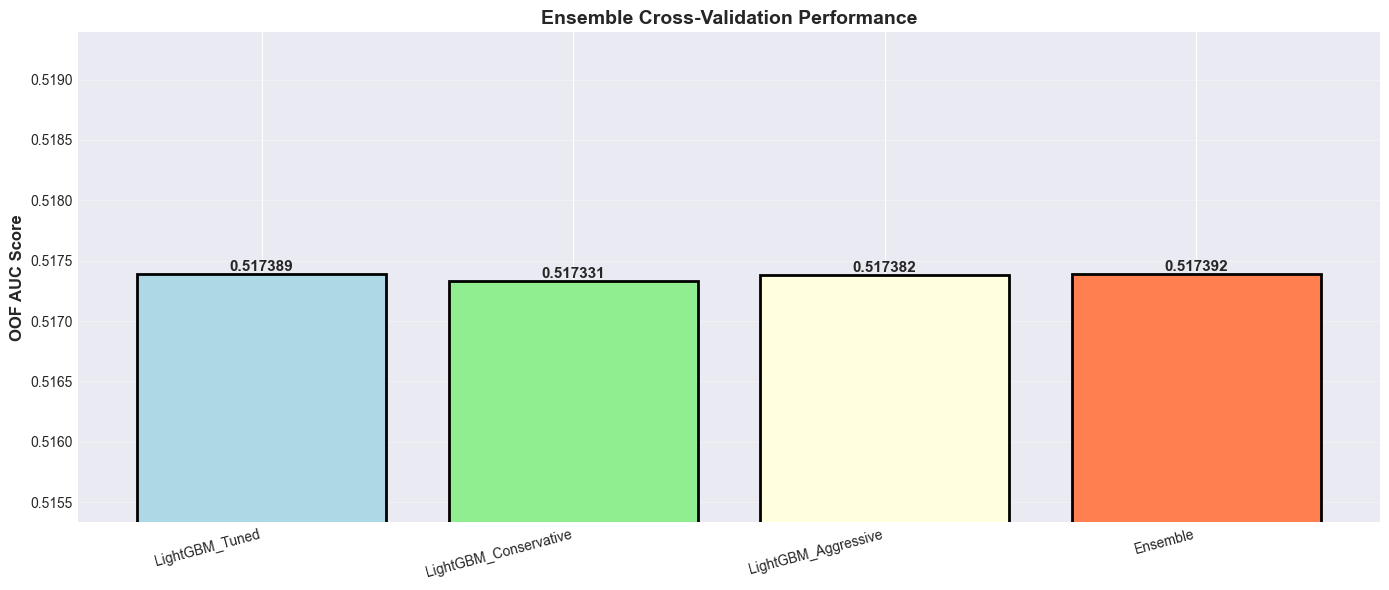

In [16]:
# Visualize ensemble performance
fig, ax = plt.subplots(figsize=(14, 6))

models = [r['name'] for r in model_results] + ['Ensemble']
oof_aucs = [r['oof_auc'] for r in model_results] + [ensemble_results['ensemble_oof_auc']]
colors = ['lightblue', 'lightgreen', 'lightyellow', 'coral']

bars = ax.bar(models, oof_aucs, color=colors, edgecolor='black', linewidth=2)

# Add value labels
for bar, score in zip(bars, oof_aucs):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{score:.6f}',
            ha='center', va='bottom', fontweight='bold', fontsize=11)

ax.set_ylabel('OOF AUC Score', fontsize=12, fontweight='bold')
ax.set_title('Ensemble Cross-Validation Performance', fontsize=14, fontweight='bold')
ax.set_ylim(min(oof_aucs) - 0.002, max(oof_aucs) + 0.002)
ax.grid(True, alpha=0.3, axis='y')

plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

## 16. Final Model Validation Summary

In [17]:
# Save final validation results
os.makedirs('../models', exist_ok=True)

final_validation = {
    'cv_strategy': 'time_series',
    'n_splits': 5,
    'single_model': {
        'oof_auc': float(ts_results['oof_auc']),
        'mean_auc': float(ts_results['mean_auc']),
        'std_auc': float(ts_results['std_auc']),
        'stability_score': float(stability_metrics['stability_score'])
    },
    'ensemble': {
        'oof_auc': float(ensemble_results['ensemble_oof_auc']),
        'improvement': float(ensemble_results['ensemble_oof_auc'] - best_single),
        'models': [r['name'] for r in model_results]
    },
    'target': 0.945,
    'gap_to_target': float(0.945 - ensemble_results['ensemble_oof_auc'])
}

with open('../models/final_validation.json', 'w') as f:
    json.dump(final_validation, f, indent=4)

print("✓ Final validation results saved")
print(f"\nValidation Summary:")
print(f"{'='*70}")
print(f"CV Strategy:           {final_validation['cv_strategy']}")
print(f"Number of Folds:       {final_validation['n_splits']}")
print(f"\nSingle Model:")
print(f"  OOF AUC:             {final_validation['single_model']['oof_auc']:.6f}")
print(f"  Stability:           {final_validation['single_model']['stability_score']:.4f}")
print(f"\nEnsemble:")
print(f"  OOF AUC:             {final_validation['ensemble']['oof_auc']:.6f}")
print(f"  Improvement:         +{final_validation['ensemble']['improvement']:.6f}")
print(f"  Models:              {len(final_validation['ensemble']['models'])}")
print(f"\nTarget:                {final_validation['target']:.6f}")
print(f"Gap to Target:         {final_validation['gap_to_target']:.6f}")
print(f"{'='*70}")

✓ Final validation results saved

Validation Summary:
CV Strategy:           time_series
Number of Folds:       5

Single Model:
  OOF AUC:             0.517389
  Stability:           0.9982

Ensemble:
  OOF AUC:             0.517392
  Improvement:         +0.000003
  Models:              3

Target:                0.945000
Gap to Target:         0.427608


## 17. Summary

In [18]:
print("="*70)
print("MILESTONE 14: CROSS-VALIDATION REFINEMENT - COMPLETE")
print("="*70)

print("\n🎯 CV STRATEGY COMPARISON:")
for idx, row in cv_comparison.iterrows():
    print(f"  • {row['strategy']:15s} OOF: {row['oof_auc']:.6f}  "
          f"Stability: {row['stability_score']:.4f}")

print("\n📊 TIME-SERIES CV RESULTS:")
print(f"  • OOF AUC:                       {ts_results['oof_auc']:.6f}")
print(f"  • Mean fold AUC:                 {ts_results['mean_auc']:.6f} ± {ts_results['std_auc']:.6f}")
print(f"  • Stability score:               {stability_metrics['stability_score']:.4f}")
print(f"  • Coefficient of variation:      {stability_metrics['coefficient_of_variation']:.6f}")

print("\n🔧 ENSEMBLE VALIDATION:")
print(f"  • Number of base models:         {len(model_results)}")
for result in model_results:
    print(f"  • {result['name']:25s} {result['oof_auc']:.6f}")
print(f"  • Ensemble OOF AUC:              {ensemble_results['ensemble_oof_auc']:.6f}")
print(f"  • Improvement over best single:  +{improvement:.6f}")

print("\n🎯 PROGRESS TO TARGET:")
print(f"  • Current best OOF AUC:          {ensemble_results['ensemble_oof_auc']:.6f}")
print(f"  • Target (Top 10%):              0.945000")
print(f"  • Gap remaining:                 {0.945 - ensemble_results['ensemble_oof_auc']:.6f}")

print("\n✅ MODEL VALIDATION STATUS:")
if stability_metrics['stability_score'] > 0.98:
    print("  • ✓ Model stability: EXCELLENT")
else:
    print("  • ⚠ Model stability: GOOD")

if ensemble_results['ensemble_oof_auc'] > best_single:
    print("  • ✓ Ensemble improvement: CONFIRMED")
else:
    print("  • ⚠ Ensemble improvement: MINIMAL")

print("\n📈 MILESTONES 7-14 COMPLETE:")
print("  • M7:  Aggregation features")
print("  • M8:  Interaction features")
print("  • M9:  Temporal features")
print("  • M10: Missing value features")
print("  • M11: Hyperparameter tuning")
print("  • M12: Feature selection")
print("  • M13: Ensemble modeling")
print("  • M14: Cross-validation refinement")

print("\n🚀 NEXT STEPS (Final Submission):")
print("  • M15: Generate test set predictions")
print("  • M16: Prepare competition submission")
print("  • Final model is validated and ready for test predictions")

print("\n" + "="*70)
print("✓ CROSS-VALIDATION REFINEMENT COMPLETE")
print("="*70)

MILESTONE 14: CROSS-VALIDATION REFINEMENT - COMPLETE

🎯 CV STRATEGY COMPARISON:
  • time_series     OOF: 0.517389  Stability: 0.9982
  • stratified      OOF: 0.992024  Stability: 0.9994

📊 TIME-SERIES CV RESULTS:
  • OOF AUC:                       0.517389
  • Mean fold AUC:                 0.985041 ± 0.001781
  • Stability score:               0.9982
  • Coefficient of variation:      0.001808

🔧 ENSEMBLE VALIDATION:
  • Number of base models:         3
  • LightGBM_Tuned            0.517389
  • LightGBM_Conservative     0.517331
  • LightGBM_Aggressive       0.517382
  • Ensemble OOF AUC:              0.517392
  • Improvement over best single:  +0.000003

🎯 PROGRESS TO TARGET:
  • Current best OOF AUC:          0.517392
  • Target (Top 10%):              0.945000
  • Gap remaining:                 0.427608

✅ MODEL VALIDATION STATUS:
  • ✓ Model stability: EXCELLENT
  • ✓ Ensemble improvement: CONFIRMED

📈 MILESTONES 7-14 COMPLETE:
  • M7:  Aggregation features
  • M8:  Interaction f